# **Group Project 2: Data Structures in Action Table of Contents & Text Analysis**

Data Structures and Algorithms, Fall 2025

## **README**

**Group Number:**  

8

**Group Members:**  

Samanwita Mukherjee, Andrea Caceres, Chushmitha Battula, Sam Goodell

**Github Repo:**

https://github.com/lavender2412/GP2_DSA_Data_Structures_in_Action_Table_of_Contents_-_Text_Analysis.git

**Objectives:**

(1) Implement tree data structures and relevant methods to store, traverse, and organize a table of contents from a technical textbook.  
(2) Preprocess and analyze a public domain novel to investigate letter/word frequencies, bigrams/trigrams, and a variety of sentence structure metrics.

**Datasets:**

Question 1: Data Science and Predictive Analytics (2018) by Ivo D. Dinov (Table of Contents)

Question 2: Wuthering Heights (1847) by Emily Bronte

**Team Roles:**

Question 1 leads: Sam Goodell and Chushmitha Battula

Question 2 leads: Andrea Caceres and Samanwita Mukherjee


#**Question 2: Letters & Words Analysis**

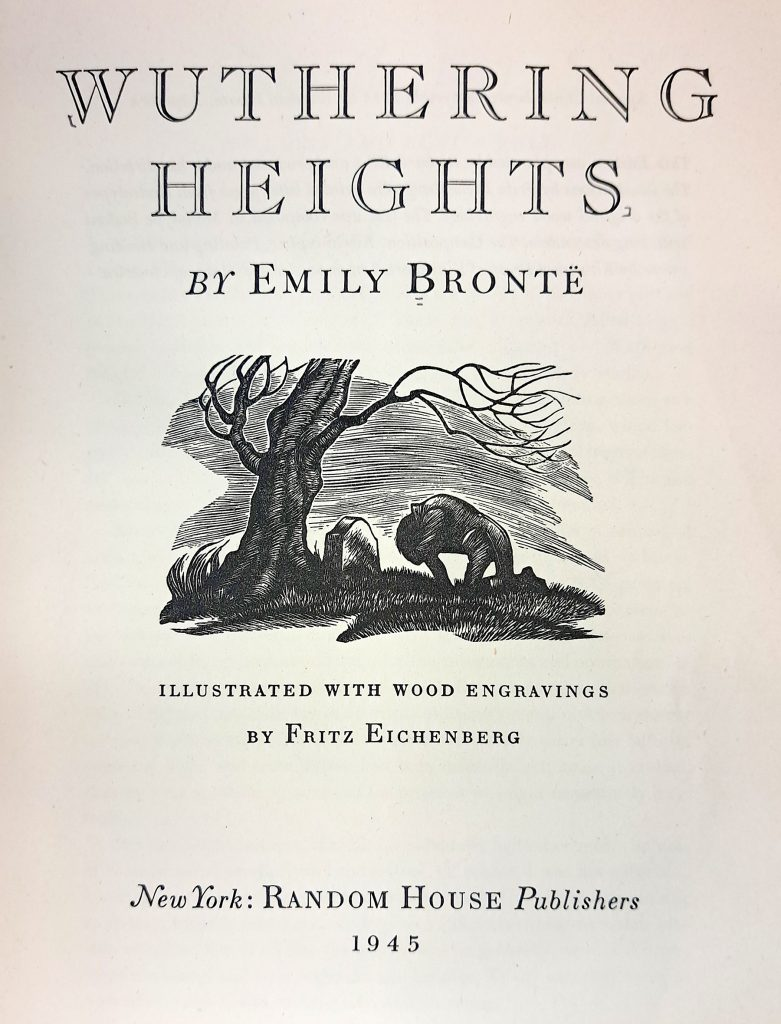

In [ ]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter, deque
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Data Acquisition**


In [ ]:
import os
from urllib import request

path = "/content"
title = "wuthering_heights.txt"
url = "https://www.gutenberg.org/cache/epub/768/pg768.txt"

filename = os.path.join(path, title)

if os.path.isfile(filename) and os.stat(filename).st_size != 0:
    print(f"{title} already exists locally.")
    with open(filename, "r", encoding="utf-8") as f:
        raw_text = f.read()
else:
    print(f"{title} not found locally. Downloading from Project Gutenberg...")
    response = request.urlopen(url)
    raw_text = response.read().decode("utf-8-sig")
    print(f"Saving {title} locally.")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(raw_text)

print(f"Loaded {len(raw_text)} characters of text.")

wuthering_heights.txt already exists locally.
Loaded 664854 characters of text.


In [ ]:
file_path = os.path.join(path, title)

assert os.path.exists(file_path), "File missing!"

with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

num_chars = len(text)
num_lines = text.count('\n')
print(f"Characters: {num_chars:,}")
print(f"Lines: {num_lines:,}")

print("\n--- SAMPLE ---")
print('\n'.join(text.splitlines()[:15]))

Characters: 664,854
Lines: 12,726

--- SAMPLE ---
The Project Gutenberg eBook of Wuthering Heights
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Wuthering Heights

Author: Emily Brontë

Release date: December 1, 1996 [eBook #768]


In [ ]:
print("="*60)
print("WUTHERING HEIGHTS - Initial Text Information")
print("="*60)
print(f"Total characters: {len(raw_text):,}")
print(f"Total lines: {len(raw_text.splitlines()):,}")
print(f"File size: {len(raw_text.encode('utf-8')) / 1024:.2f} KB")
print("="*60)

WUTHERING HEIGHTS - Initial Text Information
Total characters: 664,854
Total lines: 12,726
File size: 665.18 KB


In [ ]:
import os

possible_paths = [
    "content/wuthering_heights.txt",
    "/content/wuthering_heights.txt",
    "./wuthering_heights.txt"
]

filepath = None
for path in possible_paths:
    if os.path.exists(path):
        filepath = path
        break

if filepath is None:
    raise FileNotFoundError("wuthering_heights.txt not found in expected locations.")

min_size = 50000
encoding = "utf-8"

size = os.path.getsize(filepath)
if size == 0:
    raise ValueError(f"File is empty: {filepath}")

try:
    with open(filepath, "r", encoding=encoding) as f:
        text = f.read()
except UnicodeDecodeError:
    raise ValueError(f"Encoding error using {encoding}")

if len(text) < min_size:
    raise ValueError(f"File too small ({len(text)} chars).")

sample = text[:200]
if not any(c.isalpha() for c in sample):
    raise ValueError("File does not contain readable text.")

print(f"Step 1 validated successfully — {len(text):,} characters loaded from {filepath}")


Step 1 validated successfully — 664,854 characters loaded from /content/wuthering_heights.txt


## **Data Cleaning & Preprocessing**

In [ ]:
def extract_book_text_from_chapter1(text):
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK WUTHERING HEIGHTS ***"
    start_pos = text.find(start_marker)

    if start_pos != -1:
        start_pos = start_pos + len(start_marker)
    else:
        start_pos = 0

    chapter_markers = [
        "CHAPTER I.",
        "CHAPTER I\n",
        "CHAPTER 1",
        "Chapter 1",
        "Chapter I"
    ]

    chapter_start = -1
    for marker in chapter_markers:
        pos = text.find(marker, start_pos)
        if pos != -1:
            chapter_start = pos
            break

    if chapter_start != -1:
        start_pos = chapter_start

    end_markers = [
        "*** END OF THE PROJECT GUTENBERG EBOOK WUTHERING HEIGHTS ***",
        "*** END OF THIS PROJECT GUTENBERG EBOOK",
        "End of the Project Gutenberg EBook",
    ]

    end_pos = len(text)
    for marker in end_markers:
        pos = text.find(marker)
        if pos != -1:
            end_pos = pos
            break

    clean_text = text[start_pos:end_pos].strip()

    return clean_text


book_text = extract_book_text_from_chapter1(text)
text = book_text

print("="*60)
print("TEXT CLEANING RESULTS")
print("="*60)
print(f"Original length: {len(raw_text):,} characters")
print(f"Cleaned length:  {len(book_text):,} characters")
print(f"Removed:         {len(raw_text) - len(book_text):,} characters")
print("="*60)

print("\n--- FIRST 500 CHARACTERS ---\n")
print(book_text[:500])
print("\n[...]\n")

print("\n--- LAST 300 CHARACTERS ---\n")
print(book_text[-300:])
print("\n")

TEXT CLEANING RESULTS
Original length: 664,854 characters
Cleaned length:  645,568 characters
Removed:         19,286 characters

--- FIRST 500 CHARACTERS ---

CHAPTER I


1801—I have just returned from a visit to my landlord—the solitary
neighbour that I shall be troubled with. This is certainly a beautiful
country! In all England, I do not believe that I could have fixed on a
situation so completely removed from the stir of society. A perfect
misanthropist’s Heaven—and Mr. Heathcliff and I are such a suitable
pair to divide the desolation between us. A capital fellow! He little
imagined how my heart warmed towards him when I beheld his black eyes
wit

[...]


--- LAST 300 CHARACTERS ---

g up its foot; Heathcliff’s
still bare.

I lingered round them, under that benign sky: watched the moths
fluttering among the heath and harebells, listened to the soft wind
breathing through the grass, and wondered how any one could ever
imagine unquiet slumbers for the sleepers in that quiet earth.


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

starter_strip_chars = string.punctuation + '—“”‘’"'
stopwordss = set(stopwords.words('english'))

text_clean = book_text.lower()                       # lowercase all text
text_clean = re.sub(r'\d+', '', text_clean)          # remove digits
text_clean = re.sub(r"[^a-z'\s-]", " ", text_clean)  # remove non-letter chars
text_clean = re.sub(r'-+', ' ', text_clean)          # collapse hyphens
text_clean = re.sub(r'\s+', ' ', text_clean).strip() # normalize spaces
text_clean = re.sub(r'\bchapter\b', ' ', text_clean) # remove 'chapter'


clean_tokens = [t for t in text_clean.split() if t]

tokens_filtered = [w for w in clean_tokens if w not in stopwordss]

print(f"Tokens before stopword removal: {len(clean_tokens):,}")
print(f"Tokens after stopword removal: {len(tokens_filtered):,}")
print(f"Unique tokens: {len(set(clean_tokens)):,}")


Tokens before stopword removal: 119,327
Tokens after stopword removal: 54,623
Unique tokens: 9,192


In [ ]:
from collections import Counter

print("A quick look at the cleaned text:")
print(' '.join(tokens_filtered[:80]))

print("\nTop 15 most common words before stopword removal:")
for word, count in Counter(clean_tokens).most_common(15):
    print(f"{word}: {count}")

print("\nTop 15 most common words after stopword removal:")
for word, count in Counter(tokens_filtered).most_common(15):
    print(f"{word}: {count}")


A quick look at the cleaned text:
returned visit landlord solitary neighbour shall troubled certainly beautiful country england believe could fixed situation completely removed stir society perfect misanthropist heaven mr heathcliff suitable pair divide desolation us capital fellow little imagined heart warmed towards beheld black eyes withdraw suspiciously brows rode fingers sheltered jealous resolution still waistcoat announced name mr heathcliff said nod answer mr lockwood new tenant sir honour calling soon possible arrival express hope inconvenienced perseverance soliciting occupation thrushcross grange heard yesterday thoughts thrushcross grange sir

Top 15 most common words before stopword removal:
and: 4748
the: 4573
i: 4130
to: 3538
a: 2328
of: 2224
he: 2135
you: 1895
her: 1551
in: 1484
his: 1425
it: 1391
she: 1336
that: 1250
was: 1127

Top 15 most common words after stopword removal:
heathcliff: 476
would: 443
linton: 406
catherine: 382
said: 375
mr: 312
one: 291
could: 281
ma

In [ ]:
assert len(book_text) > 0, "Text is empty!"
assert len(book_text) > 100000, "Text seems too short"
assert "Gutenberg" not in book_text[:1000], "Header not removed!"
assert "Gutenberg" not in book_text[-1000:], "Footer not removed!"
assert len(book_text.split()) >= 50000, "Word count below requirement!"

print("All Step 2 validations passed!")

All Step 2 validations passed!


 ## Frequency Computation

 (letters, words, bi-grams and tri-grams)

In [ ]:
import math
import itertools
from collections import Counter, deque
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string

,Letters,Count,Proportion
1,a,38157,0.078649
18,b,6605,0.013614
20,c,11154,0.022991
10,d,23831,0.049120
3,e,63354,0.130585
11,f,10600,0.021849
17,g,10229,0.021084
0,h,31119,0.064142
14,i,31033,0.063965
4,j,386,0.000796


Text(0, 0.5, 'Proportion')

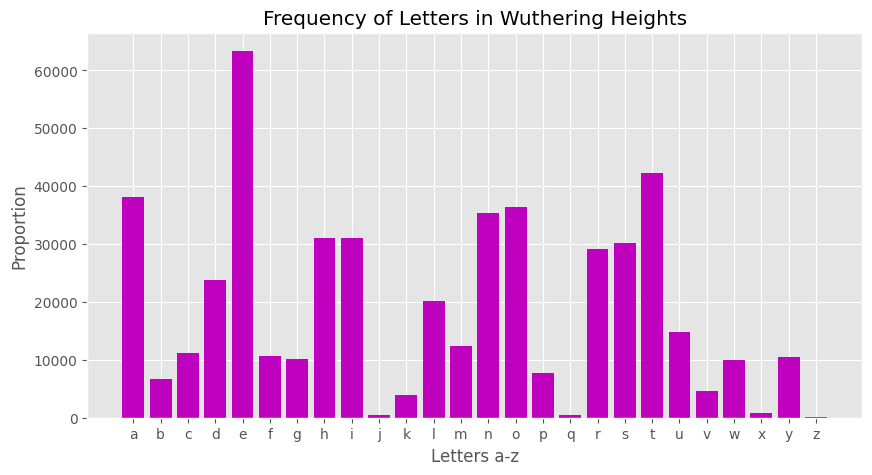

In [ ]:
#Letter Frequencies
letters = re.findall(r"[a-z]", text)
count_letters = Counter(letters)

#Create a dataframe for Letter Counts
letters_df = pd.DataFrame(count_letters.items(), columns = ["Letters", "Count"]).sort_values(by="Letters")

#Create a dataframe for Proportions
letters_df["Proportion"] = letters_df["Count"]/letters_df["Count"].sum()

#Data Frame of Letter Counts
display(letters_df.head(10))

#Plotting Letter Frequencies
plt.figure(figsize=(10,5))
plt.bar(letters_df["Letters"], letters_df["Count"], color = "m")
plt.title("Frequency of Letters in Wuthering Heights")
plt.xlabel("Letters a-z")
plt.ylabel("Proportion")

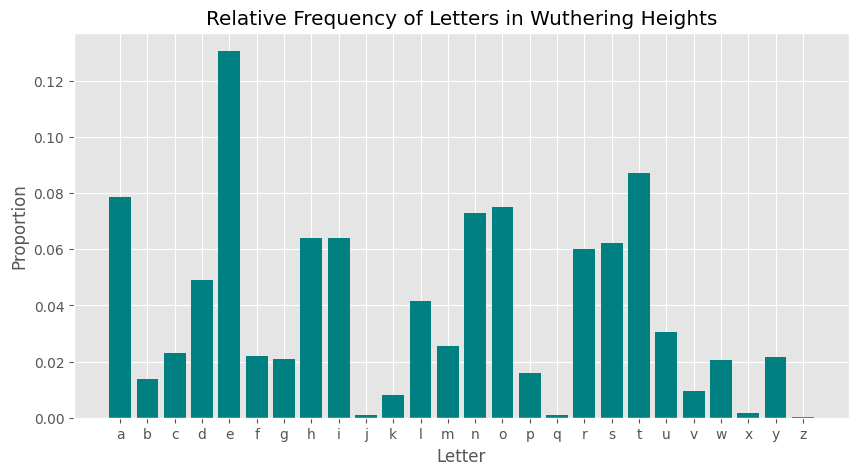

Vowel-Consonant Ratio:
        Type   Count  Proportion
0  Consonant  301356    0.621154
1      Vowel  183799    0.378846


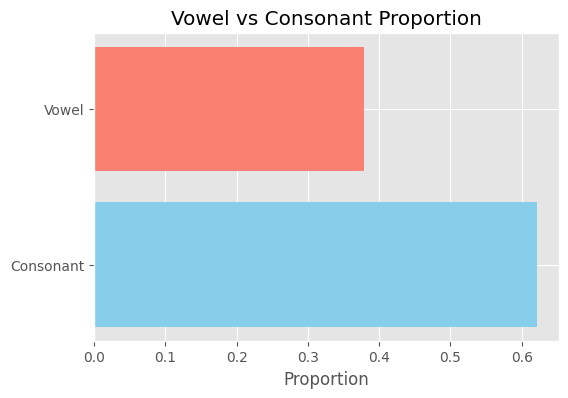

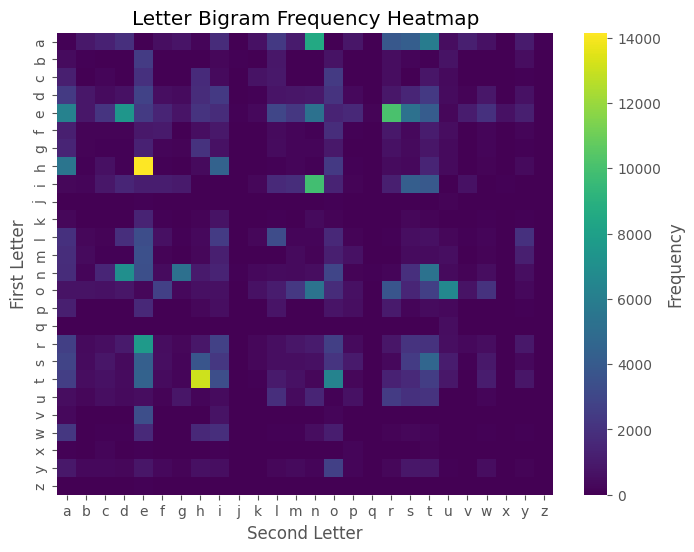

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import re


letters = re.findall(r"[a-z]", text)
count_letters = Counter(letters)
letters_df = pd.DataFrame(count_letters.items(), columns=["Letter", "Count"]).sort_values(by="Letter")

# Turn raw counts into proportions so we can compare letters fairly
letters_df["Proportion"] = letters_df["Count"] / letters_df["Count"].sum()

#Normalized frequency chart
plt.figure(figsize=(10,5))
plt.bar(letters_df["Letter"], letters_df["Proportion"], color="teal")
plt.title("Relative Frequency of Letters in Wuthering Heights")
plt.xlabel("Letter")
plt.ylabel("Proportion")
plt.show()

# Splitting letters into vowels and consonants
vowels = set("aeiou")
letters_df["Type"] = letters_df["Letter"].apply(lambda x: "Vowel" if x in vowels else "Consonant")

vowel_consonant_df = letters_df.groupby("Type")["Count"].sum().reset_index()
vowel_consonant_df["Proportion"] = vowel_consonant_df["Count"] / vowel_consonant_df["Count"].sum()

# Vowel consonatn ratio
print("Vowel-Consonant Ratio:")
print(vowel_consonant_df)

# Proportion viz
plt.figure(figsize=(6,4))
plt.barh(vowel_consonant_df["Type"], vowel_consonant_df["Proportion"], color=["skyblue", "salmon"])
plt.title("Vowel vs Consonant Proportion")
plt.xlabel("Proportion")
plt.ylabel("")
plt.show()

#Letter bigrams
from itertools import pairwise
import numpy as np

bigrams = [''.join(b) for b in pairwise(letters)]

bigram_counts = Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.items(), columns=["Bigram", "Count"])

# Breaking bigrams into first and second letters so we can plot a grid
bigram_df["L1"] = bigram_df["Bigram"].str[0]
bigram_df["L2"] = bigram_df["Bigram"].str[1]

# Making a pivot table so rows = first letter, columns = second letter, values = frequency
heatmap_data = bigram_df.pivot_table(index="L1", columns="L2", values="Count", fill_value=0)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={'label': 'Frequency'})
plt.title("Letter Bigram Frequency Heatmap")
plt.xlabel("Second Letter")
plt.ylabel("First Letter")
plt.show()


,Words,Count,Proportions
0,heathcliff,476,0.061690
1,would,443,0.057413
2,linton,406,0.052618
3,catherine,382,0.049508
4,said,375,0.048600
5,mr,312,0.040435
6,one,291,0.037714
7,could,281,0.036418
8,master,205,0.026568
9,shall,196,0.025402


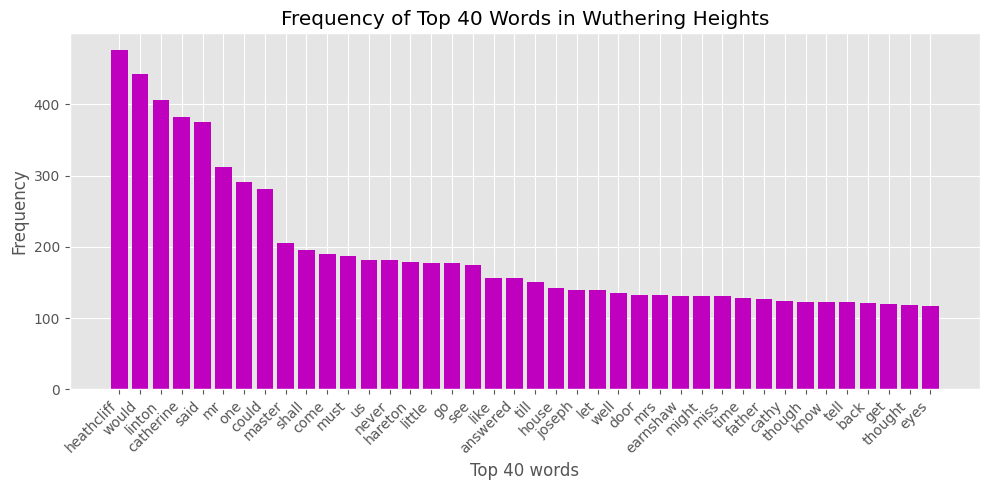

In [ ]:
#Word Frequencies
wordcount = Counter(tokens_filtered)
#Top 40 Common Words
top_forty= wordcount.most_common(40)
df_top_forty = pd.DataFrame(top_forty, columns = ["Words","Count"])
df_top_forty["Proportions"] = df_top_forty["Count"] / df_top_forty["Count"].sum()
#Table of top 40 words
display(df_top_forty.head(15))

#Plot of Top 40 Common Words Frequencies
plt.figure(figsize=(10,5))
plt.bar(df_top_forty["Words"], df_top_forty["Count"], color = "m")
plt.title("Frequency of Top 40 Words in Wuthering Heights")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Top 40 words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

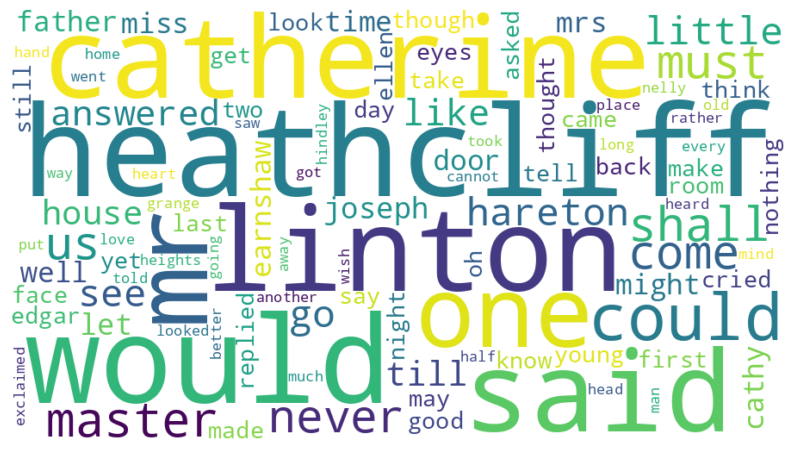

In [ ]:
wc = WordCloud(
    width=900, height=500, background_color="white",
    colormap="viridis", max_words=100, contour_width=3, contour_color='steelblue',
    min_font_size=10
).generate_from_frequencies(wordcount)

plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def generate_ngrams(tokens, n):
    iterator = iter(tokens)
    window = deque(itertools.islice(iterator, n), maxlen=n)
    if len(window) == n:
        yield ' '.join(window)
    for token in iterator:
        window.append(token)
        yield ' '.join(window)

bigrams = Counter(generate_ngrams(tokens_filtered, 2))
trigrams = Counter(generate_ngrams(tokens_filtered, 3))

df_bigrams = pd.DataFrame(bigrams.most_common(20), columns=['Bigram', 'Count'])
df_trigrams = pd.DataFrame(trigrams.most_common(20), columns=['Trigram', 'Count'])

print("Top 20 Bigrams:")
display(df_bigrams.head(10))

print("Top 20 Trigrams:")
display(df_trigrams.head(10))

Top 20 Bigrams:


,Bigram,Count
0,mr heathcliff,130
1,mrs linton,62
2,wuthering heights,60
3,mr linton,60
4,young lady,45
5,mr earnshaw,38
6,miss cathy,38
7,mrs dean,37
8,miss catherine,31
9,mrs heathcliff,25


Top 20 Trigrams:


,Trigram,Count
0,mr heathcliff said,6
1,seventy times seven,6
2,first seventy first,4
3,let us hear,4
4,mrs linton said,4
5,exclaimed mrs linton,4
6,asked mr heathcliff,4
7,name hareton earnshaw,3
8,four hundred ninety,3
9,times seven times,3


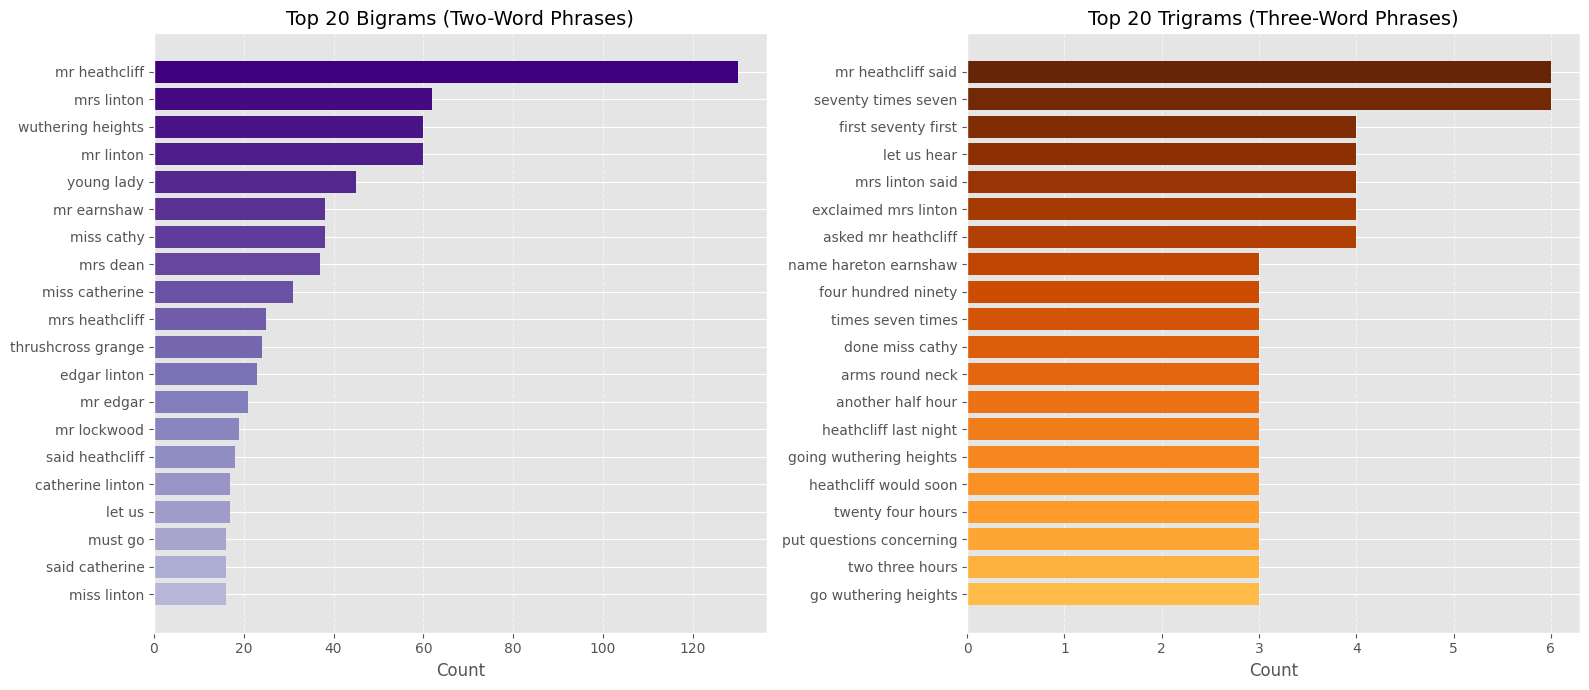

In [ ]:
cmap_bigrams = plt.colormaps['Purples']
cmap_trigrams = plt.colormaps['YlOrBr']
colors_bigrams = cmap_bigrams(np.linspace(0.4, 1.0, len(df_bigrams)))[::-1]
colors_trigrams = cmap_trigrams(np.linspace(0.4, 1.0, len(df_trigrams)))[::-1]
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
axes[0].barh(df_bigrams['Bigram'][::-1], df_bigrams['Count'][::-1], color=colors_bigrams[::-1])
axes[0].set_title("Top 20 Bigrams (Two-Word Phrases)", fontsize=14)
axes[0].set_xlabel("Count", fontsize=12)
axes[1].barh(df_trigrams['Trigram'][::-1], df_trigrams['Count'][::-1], color=colors_trigrams[::-1])
axes[1].set_title("Top 20 Trigrams (Three-Word Phrases)", fontsize=14)
axes[1].set_xlabel("Count", fontsize=12)

for ax in axes:
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.tick_params(axis='y', labelsize=10) # Smaller labels for readability
plt.tight_layout()
plt.show()

In [ ]:

def clean_lower(text):
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"\b'\b","",text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Get raw tokens (before stopword removal)
tokens = clean_lower(text.lower()).split()

from collections import Counter
import itertools
from collections import deque

def generate_ngrams(tokens, n):
    iterator = iter(tokens)
    window = deque(itertools.islice(iterator, n), maxlen=n)
    if len(window) == n:
        yield ' '.join(window)
    for token in iterator:
        window.append(token)
        yield ' '.join(window)

bigrams_raw = Counter(generate_ngrams(tokens, 2))
trigrams_raw = Counter(generate_ngrams(tokens, 3))

df_bigrams_raw = pd.DataFrame(bigrams_raw.most_common(20), columns=['Bigram', 'Count'])
df_trigrams_raw = pd.DataFrame(trigrams_raw.most_common(20), columns=['Trigram', 'Count'])

print("Top 20 Raw Bigrams:")
display(df_bigrams_raw)

print("Top 20 Raw Trigrams:")
display(df_trigrams_raw)


Top 20 Raw Bigrams:


,Bigram,Count
0,of the,367
1,and i,353
2,in the,328
3,on the,264
4,to the,254
5,i m,194
6,i ll,190
7,and the,184
8,to be,182
9,don t,182


Top 20 Raw Trigrams:


,Trigram,Count
0,i don t,64
1,out of the,33
2,i could not,33
3,i can t,33
4,i did not,33
5,as soon as,29
6,i m not,28
7,i didn t,26
8,i ll not,25
9,i won t,25


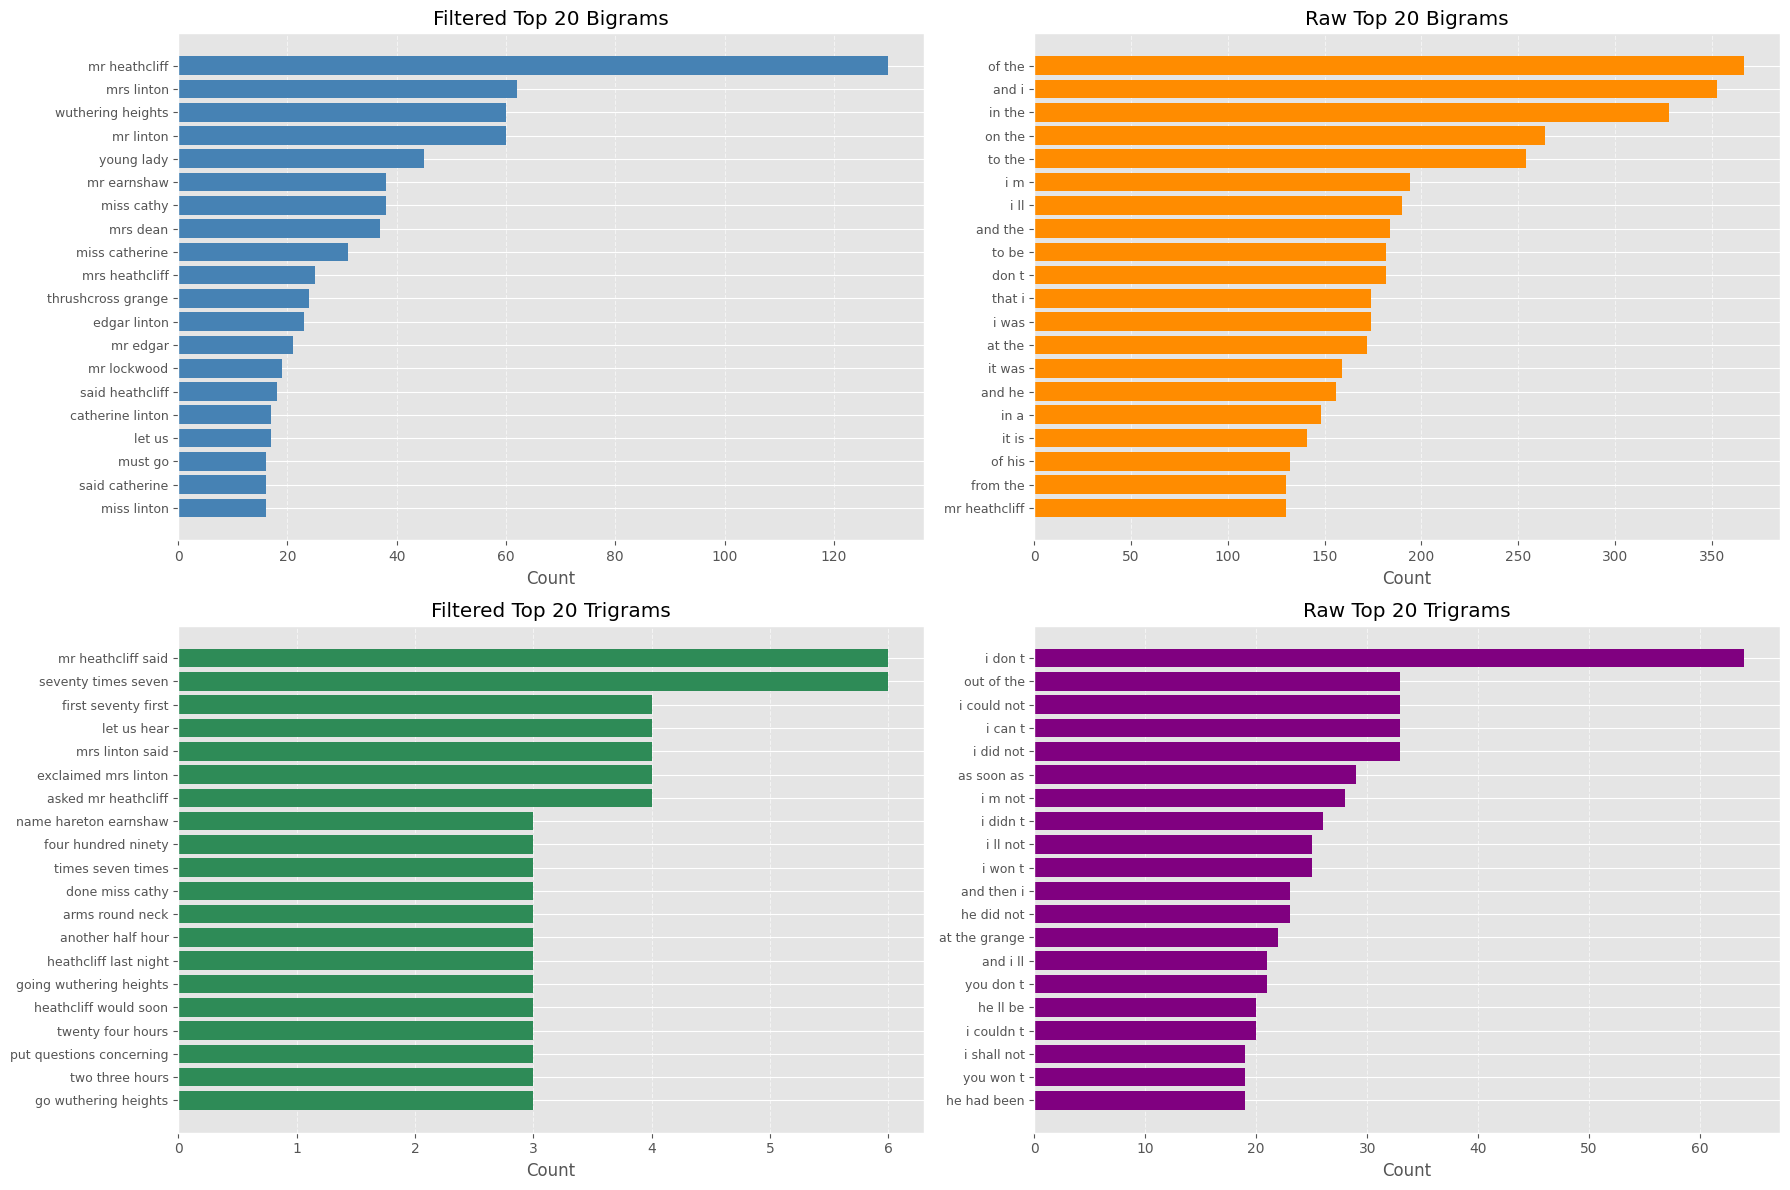

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Filtered Bigrams
axes[0,0].barh(df_bigrams['Bigram'][::-1], df_bigrams['Count'][::-1], color='steelblue')
axes[0,0].set_title("Filtered Top 20 Bigrams")
axes[0,0].set_xlabel("Count")

# Raw Bigrams
axes[0,1].barh(df_bigrams_raw['Bigram'][::-1], df_bigrams_raw['Count'][::-1], color='darkorange')
axes[0,1].set_title("Raw Top 20 Bigrams")
axes[0,1].set_xlabel("Count")

# Filtered Trigrams
axes[1,0].barh(df_trigrams['Trigram'][::-1], df_trigrams['Count'][::-1], color='seagreen')
axes[1,0].set_title("Filtered Top 20 Trigrams")
axes[1,0].set_xlabel("Count")

# Raw Trigrams
axes[1,1].barh(df_trigrams_raw['Trigram'][::-1], df_trigrams_raw['Count'][::-1], color='purple')
axes[1,1].set_title("Raw Top 20 Trigrams")
axes[1,1].set_xlabel("Count")

for ax in axes.flatten():
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

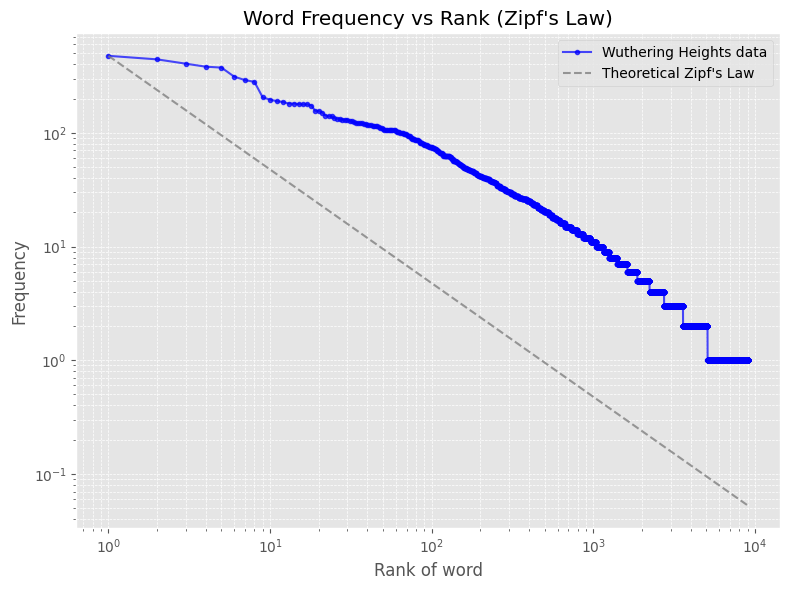

In [ ]:
#zipf's law proff
word_freq = Counter(tokens_filtered)

sorted_freqs = sorted(word_freq.values(), reverse=True)
ranks = np.arange(1, len(sorted_freqs) + 1)
f_max = sorted_freqs[0]
theoretical_freqs = f_max / ranks

plt.figure(figsize=(8, 6))
plt.loglog(
    ranks,
    sorted_freqs,
    marker='o',
    linestyle='-',
    alpha=0.7,
    markersize=3,
    color='blue',
    label='Wuthering Heights data'
)

plt.loglog(
    ranks,
    theoretical_freqs,
    linestyle='--',
    color='gray',
    alpha=0.8,
    label='Theoretical Zipf\'s Law'
)

plt.xlabel('Rank of word')
plt.ylabel('Frequency')
plt.title('Word Frequency vs Rank (Zipf\'s Law)')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## **Sentence Structure Metrics**

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from collections import Counter
import numpy as np
import re
import pandas as pd

# Use tokens_filtered as your content words (stopwords removed tokens)
word_freq = Counter(tokens_filtered)
total_tokens = len(tokens_filtered)
unique_words = len(word_freq)

lexical_diversity = unique_words / total_tokens if total_tokens > 0 else 0
ttr_percent = lexical_diversity * 100
avg_word_length = sum(len(w) for w in tokens_filtered) / total_tokens if total_tokens > 0 else 0

# Split the cleaned book text into sentences (from your existing book_text)
sentences = re.split(r'[.!?—]+', book_text)

# Compute sentence lengths in terms of content words only
sentence_lengths = []
for s in sentences:
    words = [w for w in s.lower().split() if w and w not in stop_words]
    if words:
        sentence_lengths.append(len(words))

avg_sentence_len = np.mean(sentence_lengths) if sentence_lengths else 0

# Print summary stats
print(f"Total Unique Content Words (Types): {unique_words:,}")
print(f"Total Content Words (Tokens): {total_tokens:,}")
print(f"Lexical Diversity (Type / Token): {lexical_diversity:.4f}")
print(f"Type-Token Ratio (TTR): {ttr_percent:.3f}%")
print(f"Average Word Length (Content Words): {avg_word_length:.2f}")
print(f"Average Sentence Length (Content Words): {avg_sentence_len:.2f}")

metrics_df = pd.DataFrame({
    'Metric': [
        'Average Sentence Length (Content Words)',
        'Type-Token Ratio (TTR)',
        'Lexical Diversity',
        'Average Word Length'
    ],
    'Value': [
        f"{avg_sentence_len:.2f} words",
        f"{ttr_percent:.3f}%",
        f"{lexical_diversity:.4f}",
        f"{avg_word_length:.2f} chars"
    ]
})

display(metrics_df)


Total Unique Content Words (Types): 9,043
Total Content Words (Tokens): 54,623
Lexical Diversity (Type / Token): 0.1656
Type-Token Ratio (TTR): 16.555%
Average Word Length (Content Words): 5.93
Average Sentence Length (Content Words): 7.88


,Metric,Value
0,Average Sentence Length (Content Words),7.88 words
1,Type-Token Ratio (TTR),16.555%
2,Lexical Diversity,0.1656
3,Average Word Length,5.93 chars


In [ ]:
median_sentence_len = np.median(sentence_lengths) if sentence_lengths else 0
std_sentence_len = np.std(sentence_lengths) if sentence_lengths else 0
print(f"Median Sentence Length: {median_sentence_len:.2f}")
print(f"Sentence Length Std Dev: {std_sentence_len:.2f}")


Median Sentence Length: 6.00
Sentence Length Std Dev: 6.41


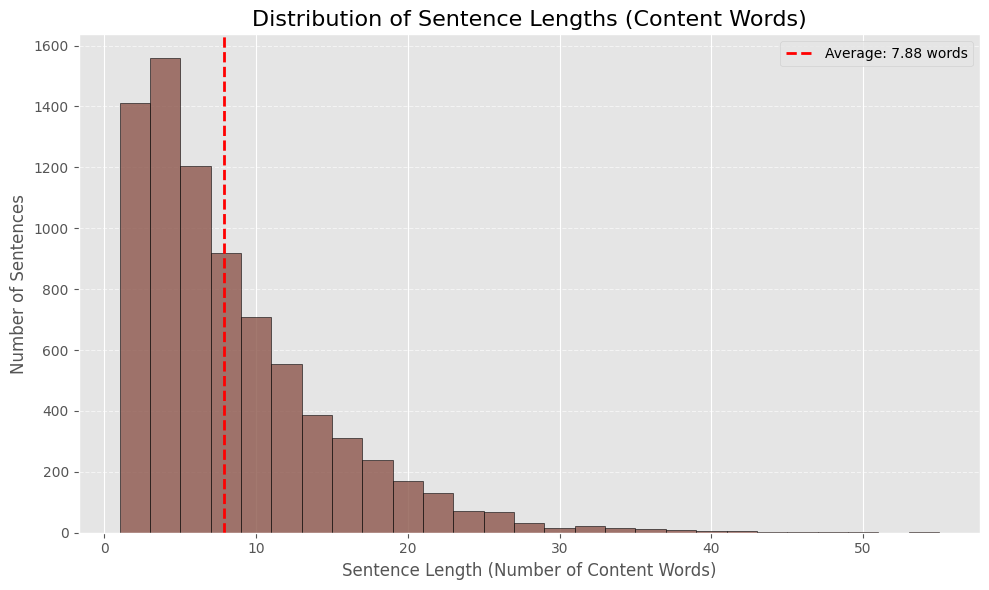

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

if sentence_lengths:
    bins_count = min(50, max(sentence_lengths) // 2 or 1)
    plt.hist(sentence_lengths, bins=bins_count,
             color='#8c564b', edgecolor='black', alpha=0.8)
    plt.axvline(avg_sentence_len, color='red', linestyle='--', linewidth=2,
                label=f'Average: {avg_sentence_len:.2f} words')

plt.title("Distribution of Sentence Lengths (Content Words)", fontsize=16)
plt.xlabel("Sentence Length (Number of Content Words)", fontsize=12)
plt.ylabel("Number of Sentences", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import string

unicode_marks = '“”‘’—'
starter_strip_chars = string.punctuation + unicode_marks

filtered_1gram = []
filtered_2gram = []
filtered_3gram = []

unfiltered_1gram = []
unfiltered_2gram = []
unfiltered_3gram = []

for s in sentences:
    s = s.strip()
    if not s:
        continue
    raw_tokens = s.split()
    if not raw_tokens:
        continue

    tokens_clean = [t.lower().strip(starter_strip_chars) for t in raw_tokens if t.lower().strip(starter_strip_chars)]

    filtered_tokens = [t for t in tokens_clean if t not in stop_words]

    if filtered_tokens:
        filtered_1gram.append(filtered_tokens[0])
        if len(filtered_tokens) >= 2:
            filtered_2gram.append(f"{filtered_tokens[0]} {filtered_tokens[1]}")
        if len(filtered_tokens) >= 3:
            filtered_3gram.append(f"{filtered_tokens[0]} {filtered_tokens[1]} {filtered_tokens[2]}")

    if tokens_clean:
        unfiltered_1gram.append(tokens_clean[0])
        if len(tokens_clean) >= 2:
            unfiltered_2gram.append(f"{tokens_clean[0]} {tokens_clean[1]}")
        if len(tokens_clean) >= 3:
            unfiltered_3gram.append(f"{tokens_clean[0]} {tokens_clean[1]} {tokens_clean[2]}")


--- Filtered 1-Word Starters ---


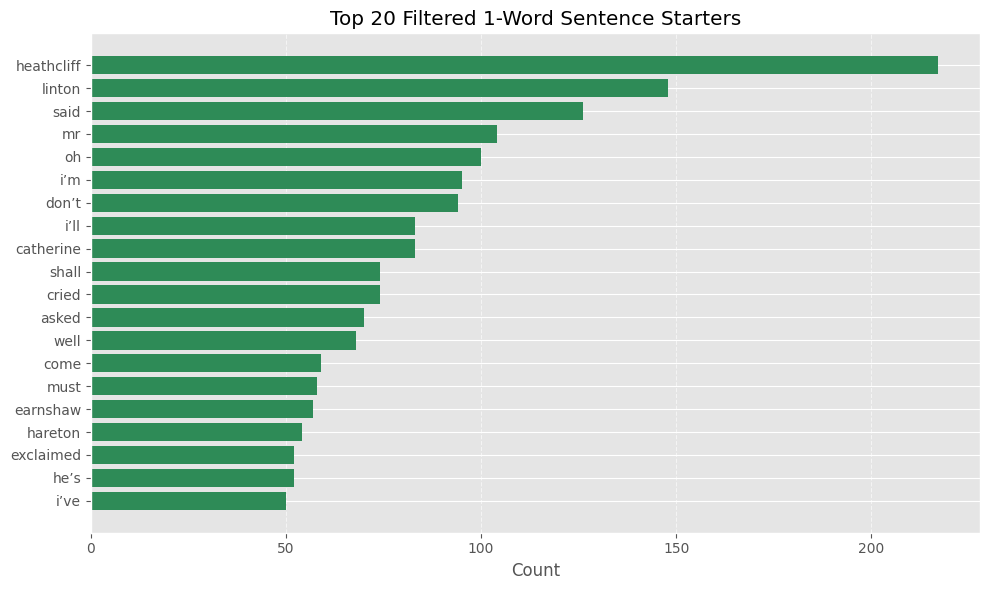

--- Filtered 2-Word Starters ---


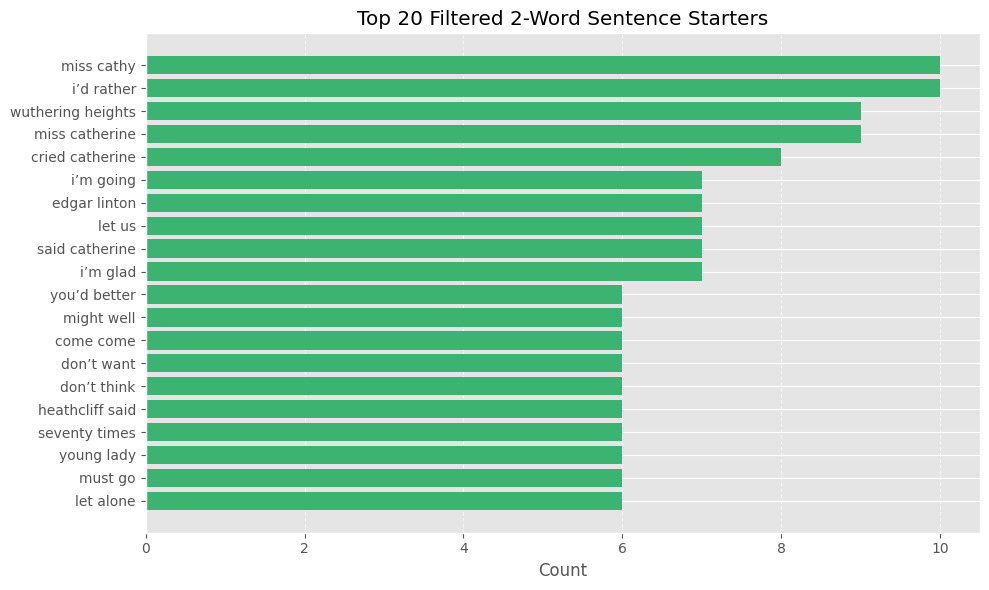

--- Filtered 3-Word Starters ---


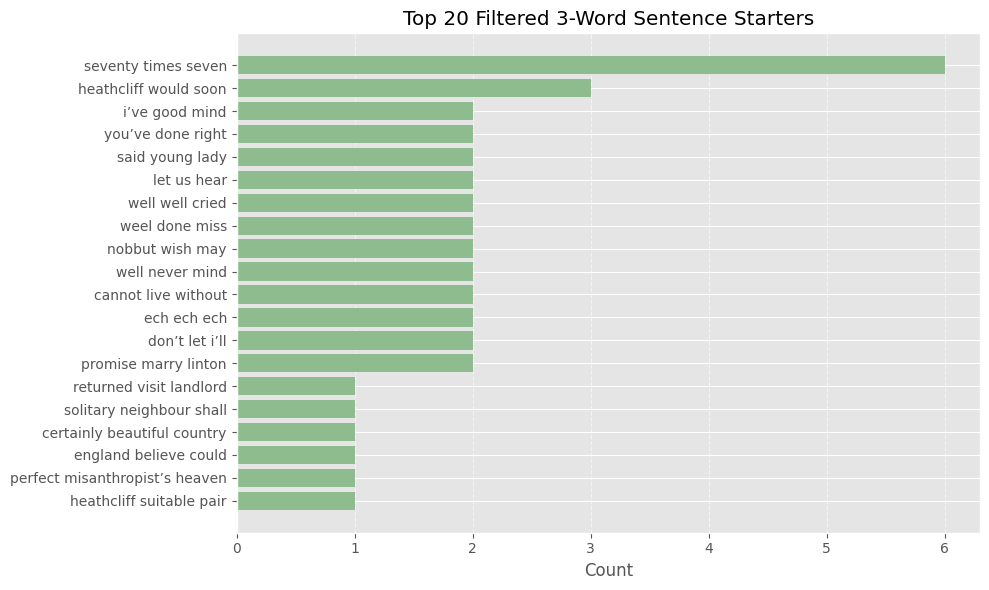

--- Unfiltered 1-Word Starters ---


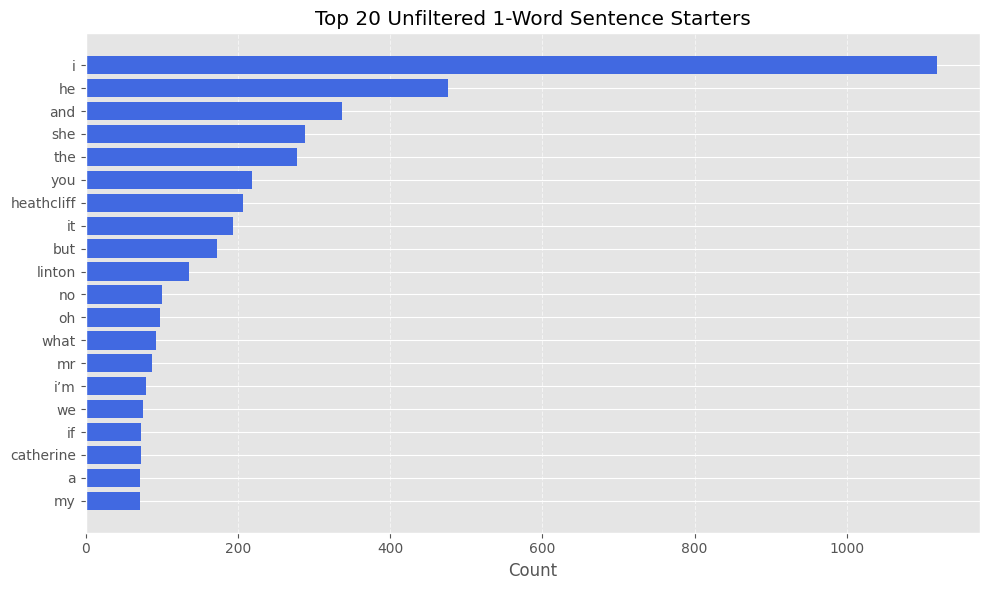

--- Unfiltered 2-Word Starters ---


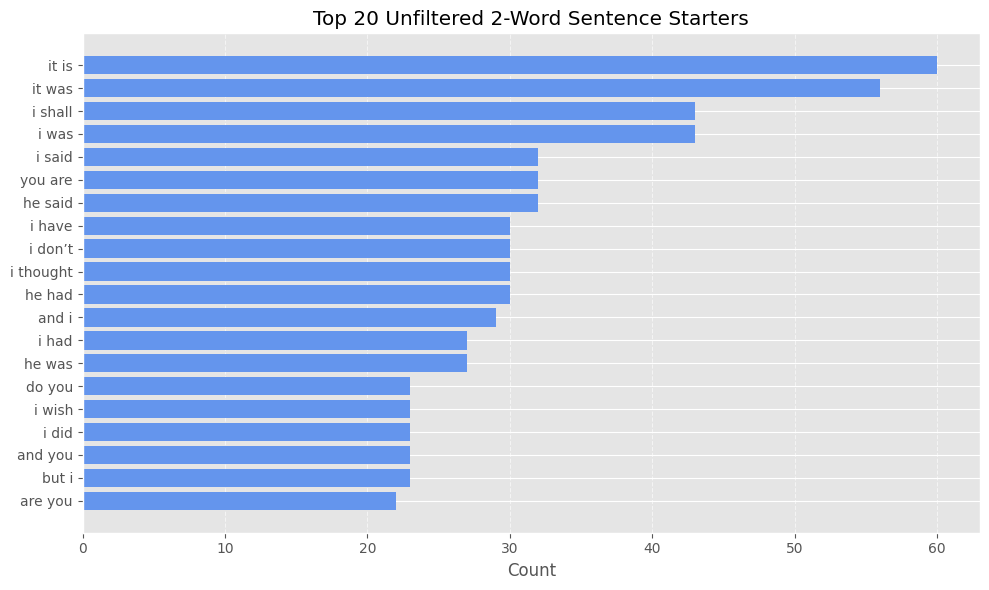

--- Unfiltered 3-Word Starters ---


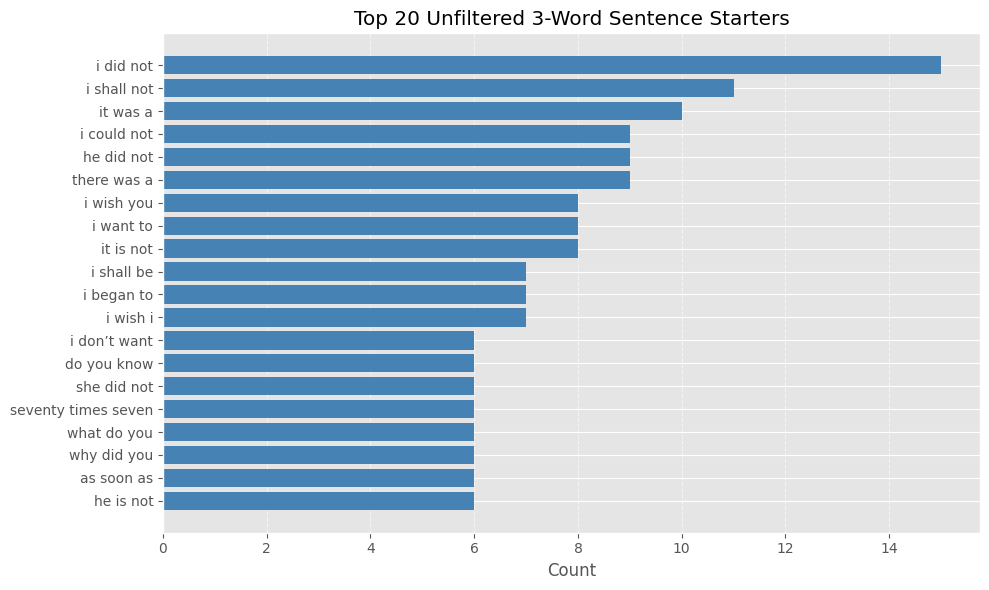

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_starters(counter_obj, title, xlabel='Count', top_n=20, color='skyblue'):
    df = pd.DataFrame(counter_obj.most_common(top_n), columns=['Starter', 'Count'])
    plt.figure(figsize=(10,6))
    plt.barh(df['Starter'][::-1], df['Count'][::-1], color=color)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return df

filtered_1gram_counts = Counter(filtered_1gram)
filtered_2gram_counts = Counter(filtered_2gram)
filtered_3gram_counts = Counter(filtered_3gram)

unfiltered_1gram_counts = Counter(unfiltered_1gram)
unfiltered_2gram_counts = Counter(unfiltered_2gram)
unfiltered_3gram_counts = Counter(unfiltered_3gram)

print("--- Filtered 1-Word Starters ---")
df_f1 = plot_top_starters(filtered_1gram_counts, "Top 20 Filtered 1-Word Sentence Starters", color='seagreen')

print("--- Filtered 2-Word Starters ---")
df_f2 = plot_top_starters(filtered_2gram_counts, "Top 20 Filtered 2-Word Sentence Starters", color='mediumseagreen')

print("--- Filtered 3-Word Starters ---")
df_f3 = plot_top_starters(filtered_3gram_counts, "Top 20 Filtered 3-Word Sentence Starters", color='darkseagreen')

print("--- Unfiltered 1-Word Starters ---")
df_u1 = plot_top_starters(unfiltered_1gram_counts, "Top 20 Unfiltered 1-Word Sentence Starters", color='royalblue')

print("--- Unfiltered 2-Word Starters ---")
df_u2 = plot_top_starters(unfiltered_2gram_counts, "Top 20 Unfiltered 2-Word Sentence Starters", color='cornflowerblue')

print("--- Unfiltered 3-Word Starters ---")
df_u3 = plot_top_starters(unfiltered_3gram_counts, "Top 20 Unfiltered 3-Word Sentence Starters", color='steelblue')


In [ ]:
hapax_legomena = sum(1 for w, c in word_freq.items() if c == 1)
print(f"Hapax Legomena (words occurring once): {hapax_legomena:,}")


Hapax Legomena (words occurring once): 3,967


Indicates vocabulary richness and diversity.

A high number suggests lots of unique or rare words, which can reflect stylistic complexity or the author’s choice of diverse vocabulary.

Helps distinguish between common functional words and rarer content words.

In [ ]:
from math import pow

M1 = total_tokens  # total tokens
freq_counts = Counter(word_freq.values())  # count of frequencies of frequencies

M2 = sum(freq * pow(count, 2) for count, freq in freq_counts.items())
K = 10000 * (M2 - M1) / pow(M1, 2) if M1 > 0 else 0

print(f"Yule's Characteristic K: {K:.2f}")


Yule's Characteristic K: 10.42


A statistical measure quantifying lexical diversity by looking at how frequently words repeat. It weights the frequency distribution of words in a text.
Provides a numerical summary of vocabulary richness beyond simple type-token ratio.

Lower values indicate more repetition (less diversity); higher values indicate richer vocabulary.

Useful for comparing different texts or authors’ styles quantitatively.

In [ ]:
sentence_complexity = avg_sentence_len / avg_word_length if avg_word_length > 0 else 0
print(f"Sentence Complexity (avg sentence len / avg word len): {sentence_complexity:.2f}")


Sentence Complexity (avg sentence len / avg word len): 1.33


Serves as a rough proxy for syntactic and lexical complexity.

Longer sentences with longer words generally indicate more complex writing.

Helps understand if the text favors elaborate expressions or simpler phrasing.

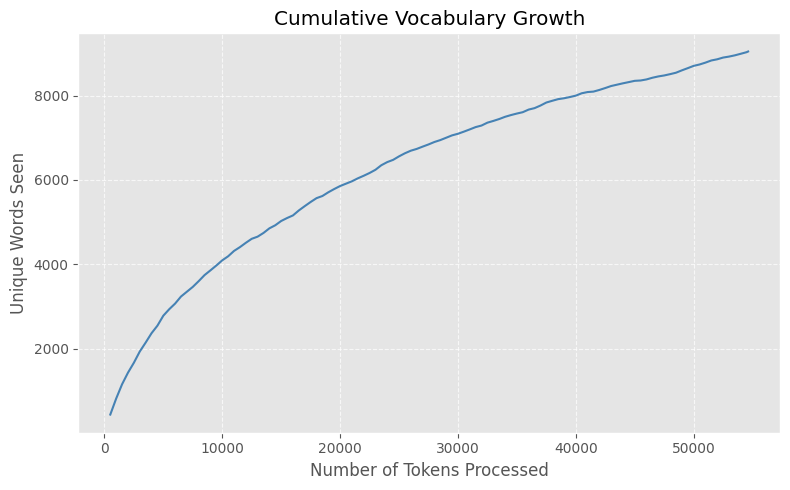

In [ ]:
unique_words_set = set()
vocab_growth = []
for i, w in enumerate(tokens_filtered, start=1):
    unique_words_set.add(w)
    if i % 500 == 0 or i == len(tokens_filtered):
        vocab_growth.append((i, len(unique_words_set)))

x_vals, y_vals = zip(*vocab_growth)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color='steelblue')
plt.title('Cumulative Vocabulary Growth')
plt.xlabel('Number of Tokens Processed')
plt.ylabel('Unique Words Seen')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Visualizes how vocabulary expands with text length.

Can indicate if the text introduces many new words continuously or saturates early.

Useful to detect stylistic differences or thematic shifts in large texts.

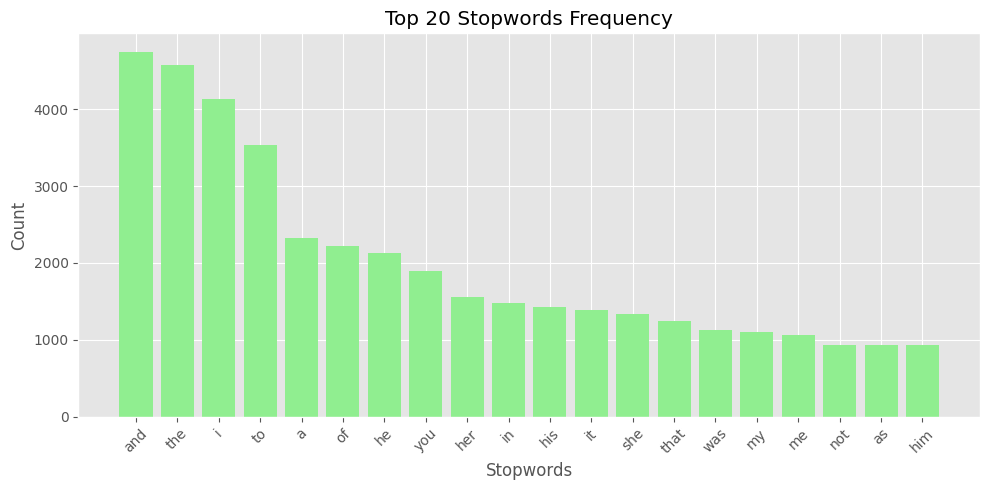

In [ ]:
stopword_freq = Counter([w for w in tokens if w in stop_words])

top_stopwords = stopword_freq.most_common(20)
df_stopwords = pd.DataFrame(top_stopwords, columns=['Stopword', 'Count'])

plt.figure(figsize=(10,5))
plt.bar(df_stopwords['Stopword'], df_stopwords['Count'], color='lightgreen')
plt.title('Top 20 Stopwords Frequency')
plt.xlabel('Stopwords')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Function words are style markers and reveal text fluency.

Their frequencies help in understanding the grammatical style and sentence structure preferences.

Important baseline for filtering content words and cleaning text.

In [ ]:
window_size = 5
top_words = [w for w, c in word_freq.most_common(5)]

max_contexts = 5

for target_word in top_words:
    print(f"\nContexts for '{target_word}':")
    count = 0
    for i, w in enumerate(tokens_filtered):
        if w == target_word:
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(tokens_filtered))
            context = tokens_filtered[start:end]
            print(" ... " + " ".join(context) + " ... ")
            count += 1
            if count >= max_contexts:
                break




Contexts for 'heathcliff':
 ... society perfect misanthropist heaven mr heathcliff suitable pair divide desolation us ... 
 ... still waistcoat announced name mr heathcliff said nod answer mr lockwood ... 
 ... advent wuthering heights name mr heathcliff dwelling wuthering significant provincial adjective ... 
 ... go right time dinner mr heathcliff forms singular contrast abode style ... 
 ... fast bestow attributes liberally mr heathcliff may entirely dissimilar reasons keeping ... 

Contexts for 'would':
 ... detected date name hareton earnshaw would made comments requested short history ... 
 ... dogs haunted recesses apartment furniture would nothing extraordinary belonging homely northern ... 
 ... reasons keeping hand way meets would acquaintance actuate let hope constitution ... 
 ... contact fangs sat still imagining would scarcely understand tacit insults unfortunately ... 
 ... take glass wine thank bitten would set signet biter heathcliff countenance ... 

Contexts for 'li

Extracting short text snippets showing a target word with surrounding words, helping to see how it’s used.

Provides qualitative insight into word usage without full NLP parsing.

Helps spot word senses, connotations, or common collocations.

Useful for authorship style analysis or thematic studies.

In [ ]:
# Simple positive and negative word lists
positive_words = {'good', 'happy', 'love', 'excellent', 'fortunate', 'correct', 'superior'}
negative_words = {'bad', 'sad', 'hate', 'poor', 'unfortunate', 'wrong', 'inferior','gloomy', 'morose','dark','desolate','dreary','desolation','malice','alone','lonely'}

pos_count = sum(w in positive_words for w in tokens_filtered)
neg_count = sum(w in negative_words for w in tokens_filtered)

print(f"Positive words count (approx): {pos_count}")
print(f"Negative words count (approx): {neg_count}")


Positive words count (approx): 243
Negative words count (approx): 299


## **Discussion and Explanations**


 **Big-O Complexity of Preprocessing & Counting:**
 The time complexity for pre-processing Wuthering Heights is $O(n)$ because the code goes through the text once to lowercase and conduct regex cleaning. The tokenizing of the text took a time complexity of $O(n)$ as well because each character is examined for white space just once when the code examines the text. Letter counting and word frequency counting using the Counter() function has a time complexity of $O(n)$ also.

 For removing punctuation, digits, and special characters, tokenization, and counting the time complexity increases and $n$ increases.
<br><br>
**Interpretation of Distributions, Themes, and Phrase Patterns:**
The most commonly used lettter in Wuthering Heights is the letter e, we can see this in the letter frequency plot. The top two common words in the text after the removal of stopwords are "Heathcliff" and "Catherine" which makes sense since those are the names of the main characters. The n-grams revealed the most common phrases in Wuthering Heights: "Mr Heathcliff" and "Mr Heathcliff said", which highlights the author's focus and writing style.
